In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

Note:
> For transformers, the argument is that *the residual stream specifically* learns
> a linear representation, due to the arguments here: [Toy Models Of SuperPosition - Feature Directions](https://transformer-circuits.pub/2022/toy_model/index.html#motivation-directions)

**Linear representations are the natural outputs of obvious algorithms a layer might implement.**

If one sets up a neuron to pattern match a particular weight template, it will fire more as a stimulus matches the template better and less as it matches it less well.

**Linear representations make features "linearly accessible."** 

A typical neural network layer is a linear function followed by a non-linearity. If a feature in the previous layer is represented linearly, a neuron in the next layer can "select it" and have it consistently excite or inhibit that neuron. If a feature were represented non-linearly, the model would not be able to do this in a single step.

**Statistical Efficiency.** 

Representing features as different directions may allow non-local generalization in models with linear transformations (such as the weights of neural nets), increasing their statistical efficiency relative to models which can only locally generalize. This view is especially advocated in some of Bengio's writing (e.g. [7]). A more accessible argument can be found in this blog post.

---

[Towards Monosemanticity - Dictionary Learning - Using Sparse Autoencoders To Find Good Decompositions](https://transformer-circuits.pub/2023/monosemantic-features/index.html#appendix-autoencoder)

* It's important to understand why making the problem overcomplete – which might initially sound like a trivial change – **actually makes this setting very different from similar approaches seeking sparse disentanglement in the literature.**
* It's closely connected to why dictionary learning is such a non-trivial operation; in fact, as we'll see, **it's actually kind of miraculous that this is possible at all.**
* At the heart of dictionary learning is an inner problem of:
  * computing the feature activations `f_i(x)` for each datapoint `x` given the feature directions `d_i`

**On its surface, this problem may seem impossible: we're asking to determine a high-dimensional vector from a low-dimensional projection**

* Put another way, we're trying to invert a very rectangular matrix.
* **The only thing which makes it possible is that we are looking for a high-dimensional vector that is sparse!**
* This is the famous and well-studied problem of **compressed** sensing, which is NP-hard in its exact form.
* It is possible to store high-dimensional sparse structure in lower-dimensional spaces, but recovering it is hard.

---

Okay so it was actually: [Interim research report - Taking features out of superposition with sparse autoencoders](https://www.lesswrong.com/posts/z6QQJbtpkEAX3Aojj/interim-research-report-taking-features-out-of-superposition) from Sharkey

* Recent results from Anthropic suggest that neural networks **represent features in superposition**.
* This motivates the search for a method that can **identify those features**.
* Here, we construct a **toy dataset of neural activations** and **see if we can recover the known ground truth features using sparse coding.**
* We show that, contrary to some initial expectations, it turns out that an extremely simple method – **training a single layer autoencoder to reconstruct neural activations with an L1 penalty on hidden activations** – doesn’t just identify features that minimize the loss, but **actually recovers the ground truth features that generated the data.**
* We’re sharing these observations quickly so that others can begin to extract the features used by neural networks as early as possible.
* We also share some incomplete observations of what happens when we apply this method to a small language model and our reflections on further research directions. 

In [2]:
# note: oh you can collapse subsections with markdown features

In [3]:
# The structure of the toy data has to be done very carefully, as it has to represent 

#### Experimental results

**The L1 penalty coefficient needs to be just right**
* When we train sparse autoencoders with different L1 penalties, we see a ‘Goldilocks zone’ in which the autoencoder recovers the ground truth features:

**We need more learned features than ground truth features**
* Fortunately, the **autoencoder appears robust to overparameterization** – it seems like we can simply increase the number of features in our learned dictionary (within reason) and it continues to reconstruct the correct features even though it has many ‘redundant’ features. This increases our confidence that we can recover ground truth features as long as we make our dictionary big enough .

**Complication: Optimal L1 penalty coefficient interacts with optimal dictionary size**
* It turns out that you need large L1 penalties for larger dictionaries.
* This complicates our search for the optimal hyperparameters because the hyperparameters are not independent and so we can’t search over hyperparameters one at a time; we have to search over both hyperparameters simultaneously.
* Nevertheless, as long as we have a reasonably large dictionary size, there is a large range of acceptable L1 penalty coefficients.
---

##### Finding the right hyperparameters without access to the ground truth

**Prescence of dead neurons**

**Loss stickiness**

**Mean max cosine similarity between a dictionary and those larger than it**

In [4]:
# Key: We suspect that real world data is often sparsely encoded (i.e. Sparse Real World Data Hypothesis)
# Example:
#     input_dimension := 4096 tokens
#     n_features := 2,000,000,000

In [5]:
import torch
import torch.nn
import torch.nn.functional

In [19]:
import matplotlib.pyplot as plt

In [6]:
import dataclasses

### Dictionary Learning

Main idea := find a basis (of different dimension size) (and corresponding coefficients) to represent input

$$ X \approx D \alpha $$

* `X` is the input data matrix
* `D` is the learned dictionary
* `alpha` is the sparse coefficient matrix

This is a change of basis to a smaller / larger dimension

So we're learning a change of basis to a smaller / larger dimension

* The main idea behind sparse dictionary learning is to represent a signal as a linear combination of a few basic elements.
* These basic elements form a dictionary, and the goal is to learn both the dictionary and the sparse coefficients that reconstruct the input data.

In [7]:
def create_shape(shape_type: str, size: int) -> torch.Tensor:
    if shape_type == 'vertical':
        return torch.cat([torch.ones(size, size//2), torch.zeros(size, size//2)], dim=1)
    elif shape_type == 'horizontal':
        return torch.cat([torch.ones(size//2, size), torch.zeros(size//2, size)], dim=0)
    elif shape_type == 'diagonal':
        return torch.eye(size)
    elif shape_type == 'cross':
        shape = torch.zeros(size, size)
        shape[size//2, :] = 1
        shape[:, size//2] = 1
        return shape
    elif shape_type == 'box':
        shape = torch.zeros(size, size)
        shape[1:-1, 1:-1] = 1
        return shape
    else:
        raise ValueError(f'Unknown shape type: {shape_type=}')

In [8]:
create_shape('cross', size=5)

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [64]:
@dataclasses.dataclass
class SyntheticData:
    X: torch.Tensor
    D: torch.Tensor
    alpha: torch.Tensor

def generate_synthetic_data(n_samples: int, n_components: int, size: int) -> torch.Tensor:

    # Define a list of interpretable shapes to include in our dictionary
    shapes = ['horizontal', 'vertical', 'diagonal', 'cross', 'box']
    
    # -- Generate the dictionary 'D' --
    
    # Create each shape, flatten it to a 1D vector, and stack them vertically
    D = torch.stack([create_shape(shape, size).flatten() for shape in shapes]).t()
    
    # Add random noise patterns to complete the dictionary
    # This simulates additional, less interpretable components
    D = torch.cat([D, torch.randn(size*size, n_components-5)], dim=1)
    
    # Normalize each column (dictionary atom) to have unit L2 norm
    # This ensures all atoms contribute equally to the reconstruction
    D = torch.nn.functional.normalize(D, p=2, dim=0)
    
    # -- Generate sparse coefficients 'alpha' --
    
    # Initialize an empty coefficient matrix
    alpha = torch.zeros(n_components, n_samples)
    
    for i in range(n_samples):
        
        # Randomly choose the number of non-zero coefficients (1 to 3)
        # This enforces sparsity in our synthetic data
        n_nonzero = torch.randint(1, 4, (1,)).item()
        
        # Randomly select which dictionary atoms will be used
        indices = torch.randperm(n_components)[:n_nonzero]
        
        # Assign random values to the selected coefficients
        alpha[indices, i] = torch.randn(n_nonzero)
    
    # Generate noisy observations 'X'
    # Multiply dictionary D with coefficients alpha to get clean signals
    # Add small Gaussian noise to simulate real-world imperfections
    X = torch.mm(D, alpha) + 0.0001 * torch.randn(size*size, n_samples)

    return SyntheticData(X, D, alpha)

In [65]:
# Set the size of each shape (8x8 pixels)
size = 8

n_samples = 100
n_components = 20

synthetic_data = generate_synthetic_data(n_samples, n_components, size)

X, true_D, true_alpha = dataclasses.astuple(synthetic_data)

In [66]:
X[0]

tensor([-3.5019e-01, -6.4386e-02, -1.8345e-01,  4.0879e-02, -1.7598e-01,
         4.3199e-01,  3.1343e-01,  1.1606e-01,  2.8548e-02,  1.5002e-01,
         1.9562e-01,  6.9792e-02, -2.7826e-01, -1.7679e-01,  1.1318e-01,
         1.0728e-02,  2.0765e-02,  3.8057e-05,  3.5186e-01, -1.2306e-01,
        -4.3723e-01,  2.6647e-01, -1.1109e-01,  3.3059e-02, -2.5890e-01,
        -1.5662e-01, -1.2286e-02, -7.3331e-03, -3.4377e-01,  3.9517e-02,
         9.3434e-02,  1.9580e-01, -2.1428e-01, -1.6902e-01,  7.6209e-02,
        -3.3028e-01, -6.5898e-02,  2.9857e-01,  1.9996e-01,  6.0103e-01,
        -5.1957e-03, -3.9220e-01, -3.6291e-02,  1.5536e-01,  2.5750e-01,
         1.2101e-01, -5.9882e-01, -2.5289e-02, -3.5704e-01,  2.4198e-03,
         3.3330e-04,  1.8646e-01,  2.2114e-01, -3.2133e-01,  3.1711e-02,
        -1.5133e-01,  3.7186e-01, -3.2872e-02, -1.0472e-01, -1.5051e-01,
         3.4489e-01,  7.1960e-02, -2.8806e-05,  3.8858e-01,  4.1673e-02,
        -2.3394e-01, -7.5881e-02,  3.9667e-02, -1.8

In [77]:
X.shape

torch.Size([64, 100])

In [67]:
true_D.shape

torch.Size([64, 20])

In [68]:
true_alpha[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.6335,  0.0000,
        -1.4071,  0.0000,  0.4316,  0.0000,  0.0000,  0.0000,  0.0000,  1.6852,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.8327,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.2003,
         0.0000, -0.0430,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4517,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

### Orthogonal Matching Pursuit
#### Key Concepts
1. **Iterative Atom Selection:** OMP iteratively selects the dictionary atoms that best explain the current residual. This greedy approach builds up a sparse representation one atom at a time.
2. **Correlation Calculation:** By computing the correlation between the residual and dictionary atoms, OMP identifies which atom can contribute most to reducing the current residual.
3. **Least Squares Solving:** After selecting atoms, OMP solves a least squares problem to find the optimal coefficients for the selected atoms. This ensures the best possible approximation using the chosen atoms.
4. **Residual Update:** After each iteration, the residual is updated by subtracting the current approximation. This focuses subsequent iterations on explaining the remaining unexplained parts of the signal.
5. **Sparsity Control:** The n_nonzero parameter controls the sparsity of the solution by limiting the number of atoms selected for each sample.
#### Algorithmic Flow
1. Initialize with the full signal as the residual.
2. Find the dictionary atom that best correlates with the residual.
3. Add this atom to the support set.
4. Solve for the best coefficients using the selected atoms.
5. Update the residual by subtracting the current approximation.
6. Repeat steps 2-5 until the desired number of atoms is selected.
7. Record the final coefficients for the selected atoms.

In [69]:
def orthogonal_matching_pursuit(
    X: torch.Tensor,
    D: torch.Tensor,
    n_nonzero: int,
) -> OMPResult:
    """
    OMP is used for the sparse coding step. 
    
    Its role is to find a sparse representation of the input data using the current dictionary.

    * Input: Data matrix X, current dictionary D
    * Output: Sparse coefficient matrix α
    * Goal: Solve the problem X ≈ Dα, where α is sparse

    """
    
    # Get the number of samples and dictionary atoms
    n_samples = X.size(1)
    n_components = D.size(1)
    
    # Initialize the sparse coefficient matrix
    alpha = torch.zeros(n_components, n_samples)
    
    # Iterate over each sample
    for i in range(n_samples):
        
        # Initialize the residual as the current sample
        residual = X[:, i].clone()
        
        # Initialize an empty support set (indices of selected atoms)
        support = []
        
        # Iterate n_nonzero times to select atoms
        for _ in range(n_nonzero):
            
            # Compute correlations between residual and dictionary atoms
            correlations = torch.abs(torch.mv(D.t(), residual))
            
            # Select the atom with the highest correlation
            new_atom = torch.argmax(correlations).item()
            
            # Add the selected atom to the support set
            support.append(new_atom)
            
            # Get the subdictionary of selected atoms
            D_support = D[:, support]
            
            # Solve the least squares problem to find coefficients
            # Returns: NamedTuple(solution, residuals, rank, singular_values)
            least_squares_result = torch.linalg.lstsq(D_support, X[:, i].unsqueeze(1))

            # print(f'{least_squares_result=}')
            alpha_support = least_squares_result.solution
            
            # Ensure alpha_support is a 1D tensor with at least one element
            alpha_support = alpha_support.flatten()

            # Update the residual by subtracting the current approximation
            residual = X[:, i] - D_support @ alpha_support
        
        # Update the sparse coefficient matrix with the found coefficients
        alpha[support, i] = alpha_support
    
    # Return the sparse coefficient matrix
    return alpha

### K-SVD
#### Key Concepts
1. **Dictionary Initialization:** The algorithm starts with a random dictionary and normalizes its atoms. This provides a starting point for the learning process.
2. **Alternating Optimization:** K-SVD alternates between sparse coding (using OMP) and dictionary update steps. This allows it to iteratively improve both the sparse representations and the dictionary.
3. **Atom-wise Update:** The dictionary update step processes one atom at a time. This allows for efficient updates and ensures that each atom is optimized to best represent the data it's responsible for.
4. **SVD for Optimal Update:** By using Singular Value Decomposition (SVD), K-SVD finds the best rank-1 approximation of the error matrix. This provides the optimal update for both the dictionary atom and its corresponding coefficients.
5. **Handling Unused Atoms:** The algorithm checks if an atom is unused (all coefficients are zero) and skips updating it. This prevents wasting computation on atoms that aren't contributing to the representation.
#### Algorithm Flow
1. Initialize the dictionary with normalized random vectors.
2. For a fixed number of iterations:
   * Perform sparse coding using OMP.
   * For each dictionary atom:
     * Identify samples using this atom.
     * Compute the residual error without this atom's contribution.
     * Use SVD to find the optimal update for the atom and its coefficients.
     * Update the atom and its coefficients.
3. Return the final dictionary and sparse coefficients.

In [82]:
def calculate_reconstruction_error(X: torch.Tensor, D: torch.Tensor, alpha: torch.Tensor) -> float:
    """
    Literally just ||X - Dα||²
    
    """
    # Calculate reconstruction error
    X_reconstructed = torch.mm(D, alpha)
    
    mse = torch.nn.functional.mse_loss(X, X_reconstructed)
    
    return mse.item()

def calculate_sparsity_loss(alpha: torch.Tensor) -> float:
    """How many of the sparse coefficients have a mean > 0"""

    # essentially how "spread out" is the representation of this sample across the basis
    return torch.mean((learned_alpha != 0).float())

@dataclasses.dataclass
class KSVDResult:
    D: torch.Tensor
    alpha: torch.Tensor

def k_svd(
    X: torch.Tensor,
    n_components: int,
    n_nonzero: int,
    n_iterations: int,
    eval_frequency: int,
) -> KSVDResult:
    """
    K-SVD is the main algorithm for dictionary learning.
    
    It iteratively updates the dictionary to better represent the input data sparsely.

    * Input: Data matrix X
    * Output: Updated dictionary D and sparse coefficient matrix α
    * Goal: Find D and α that minimize ||X - Dα||² subject to sparsity constraints on α

    """
    
    print(f"Learning K-SVD for {n_iterations=}...")
    
    # Get the dimensions of the input data
    n_features, n_samples = X.size()
    
    # Initialize the dictionary with random values
    D = torch.randn(n_features, n_components)
    
    # Normalize each dictionary atom to have unit L2 norm
    D = torch.nn.functional.normalize(D, p=2, dim=0)
    
    # Main K-SVD iteration loop
    for step in range(n_iterations):
        
        # Sparse coding step: use OMP to find sparse representations
        # Here we use OMP to essentially find the representation of each sample in our new basis `D`
        # print(f'Learning omp for step {step=} for {n_iterations=}')
        alpha = orthogonal_matching_pursuit(X, D, n_nonzero)
        
        # Dictionary update step: update each atom individually
        for j in range(n_components):
            
            # Find which samples use the current atom
            I = alpha[j, :] != 0
            
            if torch.sum(I) == 0:
                continue
            
            # Temporarily remove the contribution of the current atom
            D[:, j] = 0
            
            # Compute the residual error for samples using this atom
            E = X[:, I] - torch.mm(D, alpha[:, I])
            
            # Add back the error caused by setting the current atom to zero
            # Ensure proper broadcasting by using outer product
            E += torch.outer(D[:, j], alpha[j, I])
            
            # Perform SVD on the error matrix
            U, s, V = torch.svd(E)
            
            # Update the atom with the first left singular vector
            D[:, j] = U[:, 0]
            
            # Update the coefficients for this atom
            alpha[j, I] = s[0] * V[:, 0]

        # show reconstruction error each `eval_frequency`
        if ((step + 1) % eval_frequency) == 0:
            
            mse_loss = calculate_reconstruction_error(X, D, alpha)
            sparsity_loss = calculate_sparsity_loss(alpha)

            print(f"[{step + 1}/{n_iterations}] Reconstruction Error (MSE Loss): {mse_loss:.4f}, Sparsity loss: {sparsity_loss:.4f}")
    
    # Return the learned dictionary and sparse coefficients
    return KSVDResult(D, alpha)

In [71]:
# Note: THERE IS NOISE IN THIS DATASET so won't get to exactly 0

# learn the dictionary and sparse coefficients
ksvd_result = k_svd(
    X,
    n_components=n_components,
    n_nonzero=3, # note: this value comes from the number of nonzero coefficients selected in generate_synthetic_data
    n_iterations=100,
    eval_frequency=1,
)

learned_D, learned_alpha = dataclasses.astuple(ksvd_result)

Learning K-SVD for n_iterations=100...
[1/100] Reconstruction Error (MSE Loss): 0.0074, Sparsity loss: 0.1500
[2/100] Reconstruction Error (MSE Loss): 0.0030, Sparsity loss: 0.1500
[3/100] Reconstruction Error (MSE Loss): 0.0021, Sparsity loss: 0.1500
[4/100] Reconstruction Error (MSE Loss): 0.0016, Sparsity loss: 0.1500
[5/100] Reconstruction Error (MSE Loss): 0.0014, Sparsity loss: 0.1500
[6/100] Reconstruction Error (MSE Loss): 0.0013, Sparsity loss: 0.1500
[7/100] Reconstruction Error (MSE Loss): 0.0012, Sparsity loss: 0.1500
[8/100] Reconstruction Error (MSE Loss): 0.0011, Sparsity loss: 0.1500
[9/100] Reconstruction Error (MSE Loss): 0.0010, Sparsity loss: 0.1500
[10/100] Reconstruction Error (MSE Loss): 0.0010, Sparsity loss: 0.1500
[11/100] Reconstruction Error (MSE Loss): 0.0009, Sparsity loss: 0.1500
[12/100] Reconstruction Error (MSE Loss): 0.0009, Sparsity loss: 0.1500
[13/100] Reconstruction Error (MSE Loss): 0.0009, Sparsity loss: 0.1500
[14/100] Reconstruction Error (MSE

In [72]:
# Calculate sparsity
sparsity = torch.mean((learned_alpha != 0).float())
print(f"Average sparsity: {sparsity.item():.4f}")

Average sparsity: 0.1500


In [75]:
# Compare learned dictionary with true dictionary
similarity = torch.nn.functional.cosine_similarity(true_D.unsqueeze(1), learned_D.unsqueeze(0), dim=2)
max_similarity, _ = torch.max(similarity, dim=1)
average_similarity = torch.mean(max_similarity)
print(f"Average dictionary atom similarity: {average_similarity.item():.4f}")

Average dictionary atom similarity: 0.4914


In [ ]:
# Wait these images are a `super` powerful way to represent higher dimensional data

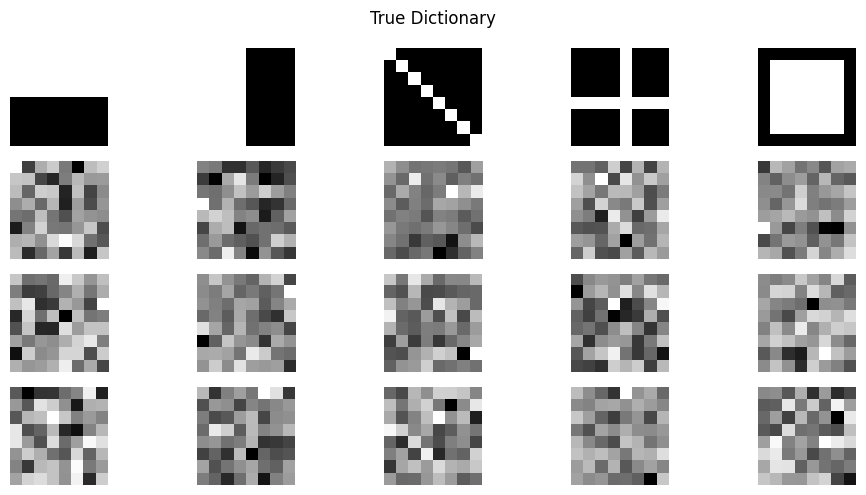

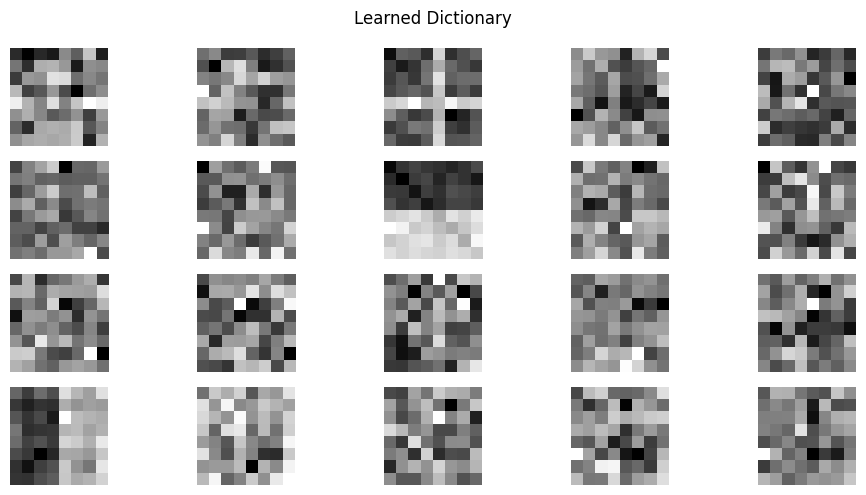

In [106]:
def plot_dictionary(D, title):
    D_cpu = D.cpu().detach().numpy()
    plt.figure(figsize=(10, 5))
    for i in range(min(20, D.size(1))):
        plt.subplot(4, 5, i+1)
        plt.imshow(D_cpu[:, i].reshape(8, 8), cmap='grey', interpolation='nearest')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_dictionary(true_D, "True Dictionary")
plot_dictionary(learned_D, "Learned Dictionary")

In [76]:
torch.nn.functional.cosine_similarity??

Docstring:
cosine_similarity(x1, x2, dim=1, eps=1e-8) -> Tensor

Returns cosine similarity between ``x1`` and ``x2``, computed along dim. ``x1`` and ``x2`` must be broadcastable
to a common shape. ``dim`` refers to the dimension in this common shape. Dimension ``dim`` of the output is
squeezed (see :func:`torch.squeeze`), resulting in the
output tensor having 1 fewer dimension.

.. math ::
    \text{similarity} = \dfrac{x_1 \cdot x_2}{\max(\Vert x_1 \Vert _2, \epsilon) \cdot \max(\Vert x_2 \Vert _2, \epsilon)}

Supports :ref:`type promotion <type-promotion-doc>`.

Args:
    x1 (Tensor): First input.
    x2 (Tensor): Second input.
    dim (int, optional): Dimension along which cosine similarity is computed. Default: 1
    eps (float, optional): Small value to avoid division by zero.
        Default: 1e-8

Example::

    >>> input1 = torch.randn(100, 128)
    >>> input2 = torch.randn(100, 128)
    >>> output = F.cosine_similarity(input1, input2)
    >>> print(output)
Type:      builtin_f

In [84]:
def pair_atoms_cosine(true_D, learned_D):
    # Compute cosine similarity between all pairs of atoms
    similarity = torch.nn.functional.cosine_similarity(true_D.unsqueeze(1), learned_D.unsqueeze(0), dim=2)
    
    # Find the best match for each true atom
    best_matches = torch.argmax(similarity, dim=1)
    
    # Create pairs and their similarity scores
    pairs = [(i, best_matches[i].item(), similarity[i, best_matches[i]].item()) for i in range(len(best_matches))]
    
    # Sort pairs by similarity score
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    return pairs

# Assuming true_D and learned_D are your dictionary tensors
pairs = pair_atoms_cosine(true_D, learned_D)

# show some arbitrary pairs, more than the 5 human interpretable ones
for true_idx, learned_idx, sim_score in pairs[:10]:
    print(f"True atom {true_idx} matched with learned atom {learned_idx} (similarity: {sim_score:.4f})")

True atom 43 matched with learned atom 24 (similarity: 0.6921)
True atom 18 matched with learned atom 32 (similarity: 0.6619)
True atom 15 matched with learned atom 61 (similarity: 0.6610)
True atom 62 matched with learned atom 12 (similarity: 0.6350)
True atom 44 matched with learned atom 42 (similarity: 0.6300)
True atom 60 matched with learned atom 15 (similarity: 0.6251)
True atom 25 matched with learned atom 10 (similarity: 0.6245)
True atom 14 matched with learned atom 53 (similarity: 0.6227)
True atom 16 matched with learned atom 11 (similarity: 0.6088)
True atom 29 matched with learned atom 8 (similarity: 0.5977)


In [93]:
true_D[43]

tensor([ 0.0000,  0.1768,  0.0000,  0.0000,  0.1667, -0.0374, -0.2162, -0.0129,
         0.0501, -0.0288,  0.0126, -0.0058, -0.0463,  0.0622,  0.0456, -0.0710,
         0.1605,  0.2170,  0.0716,  0.0359])

i=0, true_idx=43, learned_idx=24
i=1, true_idx=18, learned_idx=32
i=2, true_idx=15, learned_idx=61
i=3, true_idx=62, learned_idx=12
i=4, true_idx=44, learned_idx=42
i=5, true_idx=60, learned_idx=15
i=6, true_idx=25, learned_idx=10
i=7, true_idx=14, learned_idx=53
i=8, true_idx=16, learned_idx=11
i=9, true_idx=29, learned_idx=8
i=10, true_idx=2, learned_idx=24
i=11, true_idx=24, learned_idx=20
i=12, true_idx=7, learned_idx=58
i=13, true_idx=8, learned_idx=21
i=14, true_idx=1, learned_idx=33
i=15, true_idx=52, learned_idx=19
i=16, true_idx=26, learned_idx=57
i=17, true_idx=9, learned_idx=24
i=18, true_idx=22, learned_idx=32
i=19, true_idx=3, learned_idx=24
i=20, true_idx=31, learned_idx=63
i=21, true_idx=50, learned_idx=31
i=22, true_idx=40, learned_idx=41
i=23, true_idx=49, learned_idx=19
i=24, true_idx=12, learned_idx=61
i=25, true_idx=53, learned_idx=22
i=26, true_idx=13, learned_idx=48
i=27, true_idx=27, learned_idx=22
i=28, true_idx=34, learned_idx=10
i=29, true_idx=41, learned_idx=

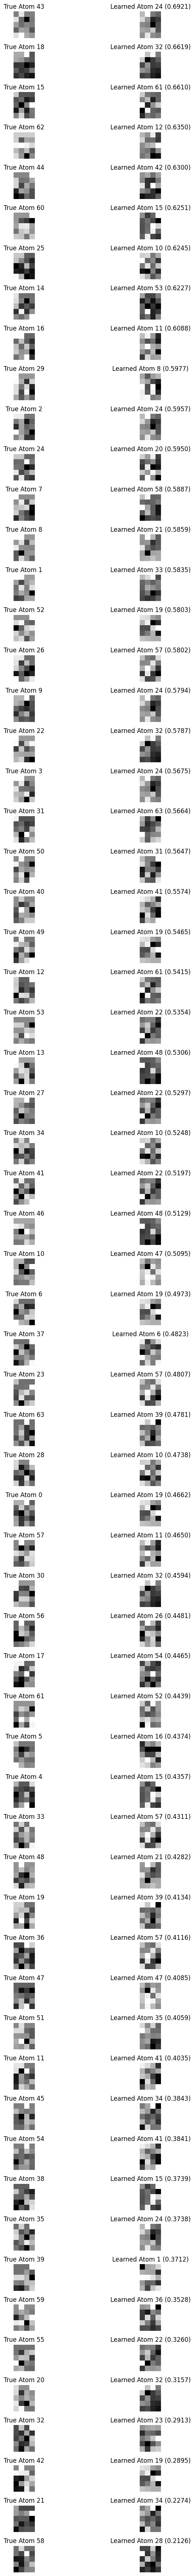

In [109]:
def plot_atom_pairs(
    true_D,
    learned_D,
    pairs,
    n_pairs: int,
):
    
    fig, axes = plt.subplots(n_pairs, 2, figsize=(10, 1.1 * n_pairs))
    
    for i, (true_idx, learned_idx, sim_score) in enumerate(pairs[:n_pairs]):
        print(f'{i=}, {true_idx=}, {learned_idx=}')

        cmap = 'grey'
        
        axes[i, 0].imshow(true_D[true_idx].reshape(5, 4), cmap=cmap, interpolation='nearest')
        axes[i, 0].set_title(f"True Atom {true_idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(learned_D[learned_idx].reshape(5, 4), cmap=cmap, interpolation='nearest')
        axes[i, 1].set_title(f"Learned Atom {learned_idx} ({sim_score:.4f})")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_atom_pairs(true_D, learned_D, pairs, n_pairs=len(pairs))